In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

In [22]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
df2 = spark.read.csv("sample_data/BostonHousing.csv",inferSchema=True,header=True)


df2.show(5)


+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler,StandardScaler,PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [24]:
only_features= ['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b','lstat']
assembler= VectorAssembler(inputCols=only_features,outputCol='features')

In [25]:
feat_df=assembler.transform(df2).select('features')

STANDARDISE DATASET

In [26]:
## Standardise the dataset
scaler= StandardScaler(inputCol='features',outputCol='scaledFeature',withMean=True,withStd=True).fit(feat_df)
df_scaled=scaler.transform(feat_df)
df_scaled.show(5)

+--------------------+--------------------+
|            features|       scaledFeature|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
+--------------------+--------------------+
only showing top 5 rows



FIT THE PCA MODEL

In [28]:
n_components=2
pca=PCA(k=n_components,inputCol='scaledFeature',outputCol='pcafeatures').fit(df_scaled)

df_pca=pca.transform(df_scaled)
print('explained variance Ratio',pca.explainedVariance.toArray())
df_pca.show(5)

explained variance Ratio [0.47129606 0.11025193]
+--------------------+--------------------+--------------------+
|            features|       scaledFeature|         pcafeatures|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [29]:
X_pca=df_pca.rdd.map(lambda row:row.pcafeatures).collect()
X_pca=np.array(X_pca)

In [30]:
X_pca

array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

In [32]:
df_pca=pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca.head()

,PC1,PC2
0,2.096223,0.772348
1,1.455811,0.591400
2,2.072547,0.599047
3,2.608922,-0.006864
4,2.455755,0.097615


Plotting two principal Components

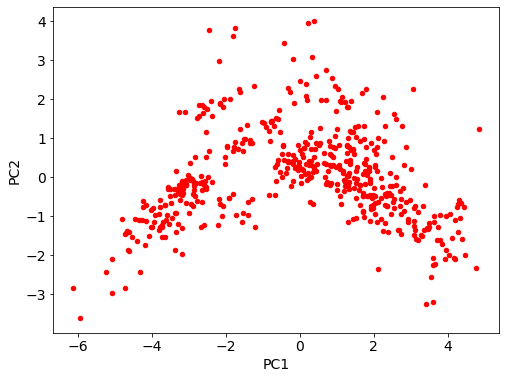

In [35]:
plt.rcParams['figure.figsize']=8,6
plt.rcParams['font.size']=14
ax1=df_pca.plot.scatter(x='PC1',y='PC2',c='red')

LINEAR REGRESSION USING SPARK

In [38]:
output=assembler.transform(df2)
f_data=output.select('features','medv')
f_data.show(5)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
+--------------------+----+
only showing top 5 rows



In [65]:
train_data,test_data= f_data.randomSplit([0.90,0.1])

TRAINING THE MODEL

In [66]:
regressor=LinearRegression(featuresCol='features',labelCol='medv')
regressor=regressor.fit(train_data)

Print model Coefficient and intercept

In [67]:
coeff=regressor.coefficients
intr=regressor.intercept
print("The coefficient of the model is found to be:", coeff)
print("The intercept of the model is found to be:", intr)

print("The coefficient of the model is found to be: %a" %coeff)
print("The intercept of the model is found to be: %f" %intr)


The coefficient of the model is found to be: [-0.1106042054064601,0.05289825696733753,-0.005026103412421389,2.6406536130723426,-18.746357110096678,3.438915747753576,-0.003782633995144968,-1.6574606113991865,0.301616080820211,-0.011454544432174025,-0.9325739453162533,0.009496685325631155,-0.5292438810433121]
The intercept of the model is found to be: 39.86851594454367
The coefficient of the model is found to be: DenseVector([-0.1106, 0.0529, -0.005, 2.6407, -18.7464, 3.4389, -0.0038, -1.6575, 0.3016, -0.0115, -0.9326, 0.0095, -0.5292])
The intercept of the model is found to be: 39.868516


Evaluate the Model of the Test Dataset

In [68]:
pred= regressor.evaluate(test_data)
pred.predictions.show(5)

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.01096,55.0,2.2...|22.0|27.421887455857846|
|[0.01501,80.0,2.0...|24.5| 27.49685706287947|
|[0.01951,17.5,1.3...|33.0| 22.46203417094221|
|[0.02763,75.0,2.9...|30.8|31.862678697360792|
|[0.03359,75.0,2.9...|34.9|34.598345870841825|
+--------------------+----+------------------+
only showing top 5 rows



Calculate Model Statistics

In [69]:
from pyspark.ml.evaluation import RegressionEvaluator
eval=RegressionEvaluator(labelCol='medv',predictionCol='prediction',metricName='rmse')

rmse=eval.evaluate(pred.predictions)
print("RMSE : %.3f" %rmse)

mse=eval.evaluate(pred.predictions,{eval.metricName:"mse"})
print("MSE : %.3f" %mse)

mae=eval.evaluate(pred.predictions,{eval.metricName:"mae"})
print("MAE : %.3f" % mae)

r2=eval.evaluate(pred.predictions,{eval.metricName:"r2"})
print("r2 : %.3f" %r2)

RMSE : 4.161
MSE : 17.316
MAE : 3.161
r2 : 0.813
